In [64]:
import pandas as pd
import numpy as np
import scanpy as sc
import sf_utils

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statannotations.Annotator import Annotator
from sklearn.neighbors import kneighbors_graph

import seaborn as sns
import os

sc.settings.set_figure_params(dpi=80, facecolor='white', fontsize=14, scanpy=True, format='pdf')
sc.set_figure_params(figsize=(5,5))

sc.settings.verbosity=3

In [65]:
adata = sc.read_h5ad("../rna_analysis/proc_files/lsk_rna_doub_remv2.h5ad")

In [66]:
#add atac celltype
adata.obs['final_celltype'] = adata.obs['cell_type2']

#add simplified celltypes
adata.obs['final_celltype_simplified'] = np.array(adata.obs['final_celltype'].values)

#merge all progenitors
adata.obs.loc[adata.obs.final_celltype.isin(["MEP","MPP","MPP/GMP"]),'final_celltype_simplified'] = "Progenitors"

#merge Mast with Ery/Meg
adata.obs.loc[adata.obs.final_celltype.isin(["Mast","Baso/Eos"]),'final_celltype_simplified'] = "Baso/Eos/Mast"

#merge all unknowns
adata.obs.loc[adata.obs.final_celltype.isin(["Unk_1","Unk_2","Unk_3"]),'final_celltype_simplified'] = "Unknown"

# adata.obs.loc[adata.obs.final_celltype.isin(["Lym",'pDC','Ccr7_DC']),'final_celltype_simplified'] = "Lym/DC"

In [67]:
pal_coords = pd.read_csv("../lsk_rna_proc/proc_files/intdata_doub_rem_meta_palantir_umap.csv", index_col=0)
pal_coords.index = pal_coords.index.map(lambda x:f'{x.split("-")[0]}-rna-{x[5:-4]}')

In [68]:
# adata.obs_names = adata.obs_names.map(lambda x:f'{x.replace("-rna-","-")}-rna')

In [69]:
pal_coords = pal_coords.reindex(index=adata.obs_names).copy()

In [70]:
adata.obsm['X_umap'] = pal_coords.values

In [71]:
adata.obs['day'] = adata.obs_names.map(lambda x:x[:2])

In [72]:
adata.uns['final_celltype_simplified_colors'] = ['#20591b','#ff5c0c','#ffb92b',
                                                '#878fc3','#d02011','#1138a8','#d3d3d2','#d3d3d2','#76067b']

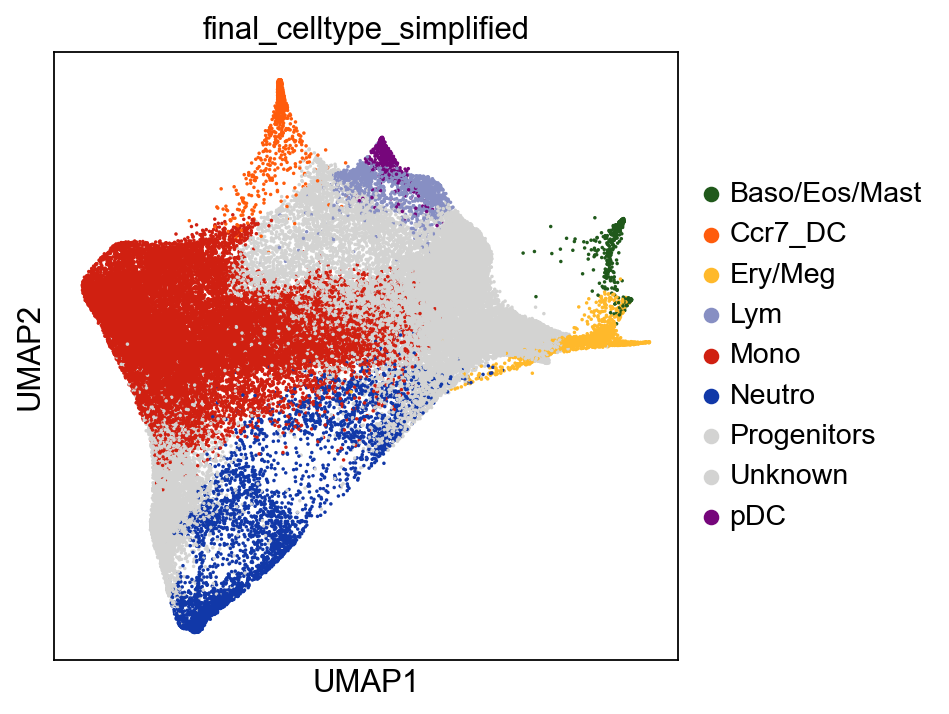

In [73]:
sc.pl.umap(adata,color='final_celltype_simplified', s=10)

In [74]:
adata.obs['day'].cat.reorder_categories(['d5','d2'], inplace=True)

/var/folders/sb/tb3flv3j67bfx_p7fm60_qd00000gq/T/ipykernel_49040/1230589857.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['day'].cat.reorder_categories(['d5','d2'], inplace=True)


In [77]:
adata.uns['day_colors'][0] = '#550000'
adata.uns['day_colors'][1] = '#ff990c'

/Users/jindalk/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/jindalk/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


<AxesSubplot:title={'center':'day'}, xlabel='UMAP1', ylabel='UMAP2'>

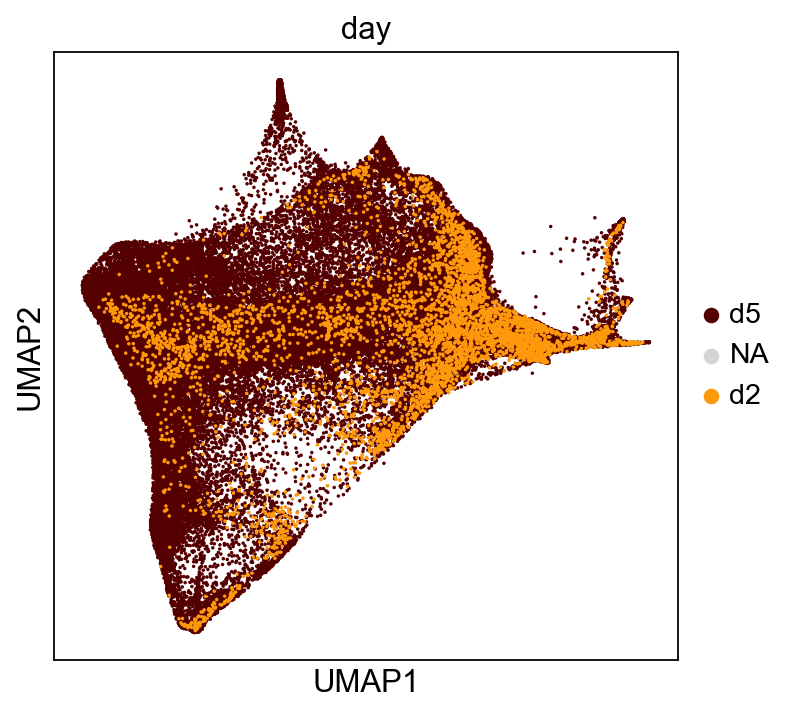

In [78]:
ax=plt.axes()
sc.pl.umap(adata,color='day', s=10, groups="d5", ax=ax, show=False)
sc.pl.umap(adata[adata.obs.day=='d2'],color='day', s=10, groups="d2", ax=ax, show=False)

/Users/jindalk/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/jindalk/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


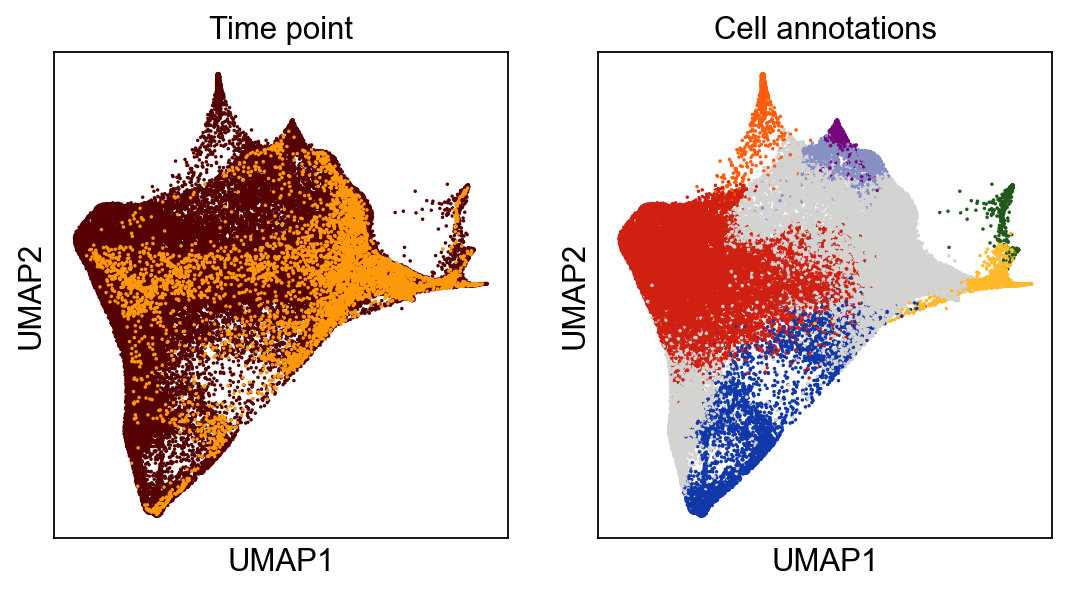

In [80]:
#run on object with whole clones
fig = plt.figure(figsize=(8,4))
gs = GridSpec(1,2)

ax = plt.subplot(gs[0])
sc.pl.umap(adata,color='day', s=10, groups="d5", ax=ax, show=False, legend_loc="")
sc.pl.umap(adata[adata.obs.day=='d2'],color='day', s=10, groups="d2", ax=ax, show=False, legend_loc="")
plt.title('Time point')


ax = plt.subplot(gs[1])
sc.pl.umap(adata, color='final_celltype_simplified', s=10, ax=ax, show=False, legend_loc='')
plt.title('Cell annotations')

plt.savefig("221122_plots/rna_umap_day_fate.pdf", dpi=200)

In [81]:
clones_og = pd.read_csv("../hsc.rna&atac.r1&2_master_v2.csv")
# clones_og = clones_og[clones_og['assay']=='rna'].copy()
clones_rna = pd.read_csv("../celltag_analysis/proc_files/clone_table_RNA_onlylsk_multijac_reanalysis.csv", index_col=0)

In [82]:
clones_og.index = clones_og['cell.bc']
# remove_clones = clones_og['clone.id'].value_counts()[clones_og['clone.id'].value_counts() == 1].index
# clones_og = clones_og[~clones_og['clone.id'].isin(remove_clones)].copy()

In [83]:
#remove cells not in adata; remove clones with one sister post filtering
clones_rna = clones_rna[clones_rna['cell.bc'].isin(adata.obs_names)].copy()
clones_rna = clones_rna[clones_rna['clone.id'].isin(clones_rna['clone.id'].value_counts()[
    clones_rna['clone.id'].value_counts() > 1].index)].copy()
clones_rna.reset_index(drop=True, inplace=True)


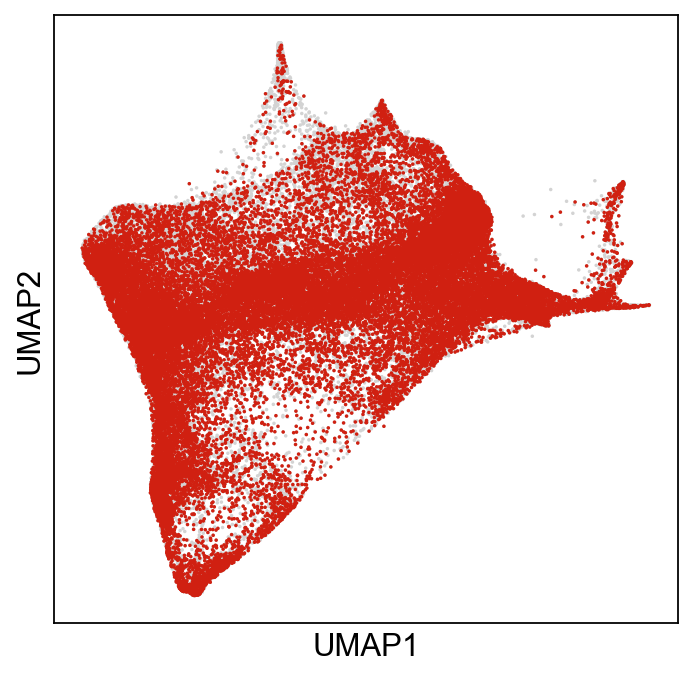

In [96]:
ax=plt.axes()
sc.pl.umap(adata, ax=ax,show=False, s=10)
sc.pl.umap(adata[adata.obs_names.isin(clones_rna['cell.bc'])], ax=ax,show=False, na_color="#d02011", s=10)
plt.savefig("./221122_plots/rna_umap_cells_in_clones.pdf", dpi=200)

In [21]:
# clones_rna

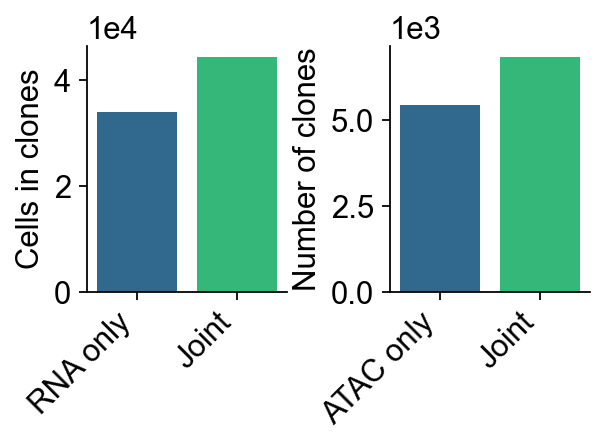

In [132]:
plt.figure(figsize=(4,3))
gs=GridSpec(1,2)

ax=plt.subplot(gs[0])
sns.barplot(x = ['RNA only', 'Joint'],y=[len(clones_rna), len(clones_og)],palette='viridis', saturation=1, ax=ax)
plt.grid(False)
plt.xlabel("")
plt.ylabel("Cells in clones")
plt.xticks(ticks=[0,1], labels=['RNA only', 'Joint'], rotation=45, ha='right')
# plt.yticks(rotation=0, labels=[1,2,3,4])

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax=plt.subplot(gs[1])
sns.barplot(x = ['RNA only', 'Joint'],y=[len(clones_rna['clone.id'].unique()), len(clones_og['clone.id'].unique())],palette='viridis', saturation=1, ax=ax)
plt.grid(False)
plt.xlabel("")
plt.ylabel("Number of clones")
plt.xticks(ticks=[0,1], labels=['ATAC only', 'Joint'], rotation=45, ha='right')
# plt.yticks(rotation=0, labels=[1,2,3,4])

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tight_layout()

plt.savefig("./221122_plots/rna_vs_joint_barplots.pdf")

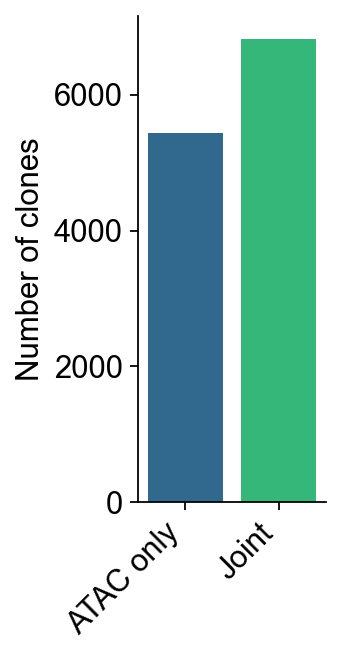

In [99]:
plt.figure(figsize=(1.5,4))


# Rand Index

In [100]:
common_cells = set(clones_og['cell.bc'].values).intersection(set(clones_rna['cell.bc'].values))
clones_rna_sub = clones_rna[clones_rna['cell.bc'].isin(common_cells)].copy()
clones_og_sub = clones_og[clones_og['cell.bc'].isin(common_cells)].copy()

In [101]:
clones_rna_sub.index = clones_rna_sub['cell.bc']

In [102]:
clones_rna_sub = clones_rna_sub.loc[clones_og_sub.index].copy()

In [103]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(clones_og_sub['clone.id'], clones_rna_sub['clone.id'])

0.9620250087565221

# State fate viz

In [104]:
#merge lymphoids and DCs
adata.obs['final_celltype_simplified'] = np.array(adata.obs['final_celltype_simplified'])
adata.obs.loc[adata.obs.final_celltype.isin(["Lym",'pDC','Ccr7_DC']),'final_celltype_simplified'] = "Lym/DC"

In [105]:
clones_rna = clones_rna.merge(adata.obs[['cell_type2']], right_index=True, left_on="cell.bc").copy()

In [106]:
clones_rna['day'] = clones_rna['cell.bc'].apply(lambda x:x[:2])

In [107]:
#redo clone fate assignment with new lym fates
clones_rna['cell_type2'] = np.array(clones_rna['cell_type2'])
clones_rna.loc[clones_rna.cell_type2.isin(['Lym','pDC','Ccr7_DC']), 'cell_type2'] = 'Lym/DC'
clones_rna.loc[clones_rna.cell_type2.isin(['Baso/Eos','Mast']), 'cell_type2'] = 'Baso/Eos/Mast'
# clones_rna.drop(columns=['fate','fate_pct'], inplace=True)

def assign_fate(clone_mtx):
    clone_mtx_curr = clone_mtx[clone_mtx['day'] == 'd5'].copy()
    if(len(clone_mtx_curr) == 0):
        clone_mtx['fate'] = 'no_fate_cells'
        clone_mtx['fate_pct'] = 0
    else:
        clone_mtx['fate'] = clone_mtx_curr['cell_type2'].value_counts(dropna=False).sort_index().idxmax()
        clone_mtx['fate_pct'] = 100*clone_mtx_curr['cell_type2'].value_counts(dropna=False).sort_index().max()/len(clone_mtx_curr)
    return clone_mtx


new_table = pd.DataFrame()

for _,i in clones_rna.groupby("clone.id"):
    clone_curr = assign_fate(i).copy()
    new_table = pd.concat((new_table,clone_curr))

In [108]:
# new_table

In [111]:
clones_rna = new_table.copy()

In [112]:
fates = clones_rna['fate'].unique()
fates = ['Mono', 'Baso/Eos/Mast', 'Neutro', 'Ery/Meg', 'Lym/DC']

umap_df = pd.DataFrame(data=adata.obsm['X_umap'],
                      index=adata.obs_names,
                      columns=['UMAP_1','UMAP_2']).copy(deep=True)

In [113]:
adata.uns['final_celltype_simplified_colors']

['#20591b',
 '#ff5c0c',
 '#ffb92b',
 '#878fc3',
 '#d02011',
 '#1138a8',
 '#d3d3d2',
 '#d3d3d2',
 '#76067b']

In [114]:
adata.uns['final_celltype_simplified_colors'] = ['#21581c', '#ffb92c', '#878fc3', '#d11e11', '#1139a8','#d3d3d2', '#d3d3d1']

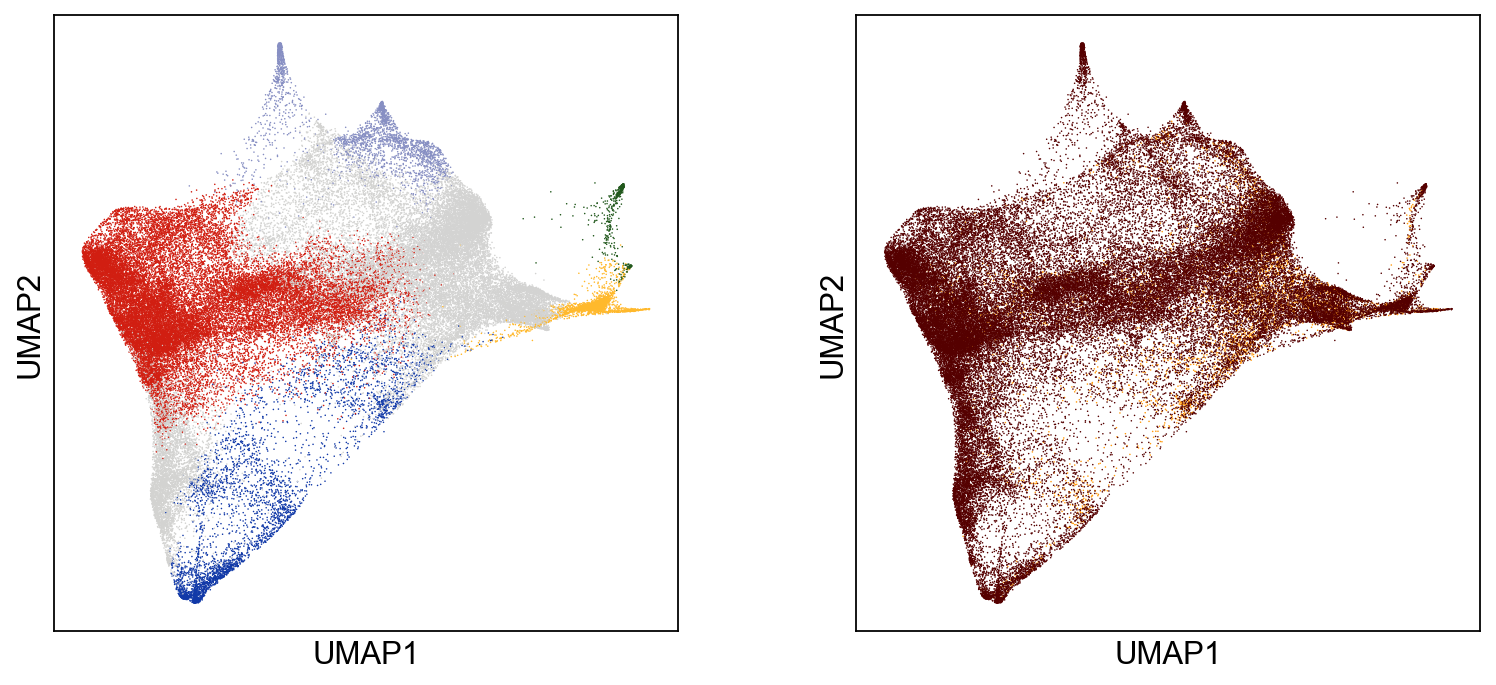

In [115]:
sc.pl.umap(adata, color=['final_celltype_simplified','day'], legend_loc=None, title=["",""])

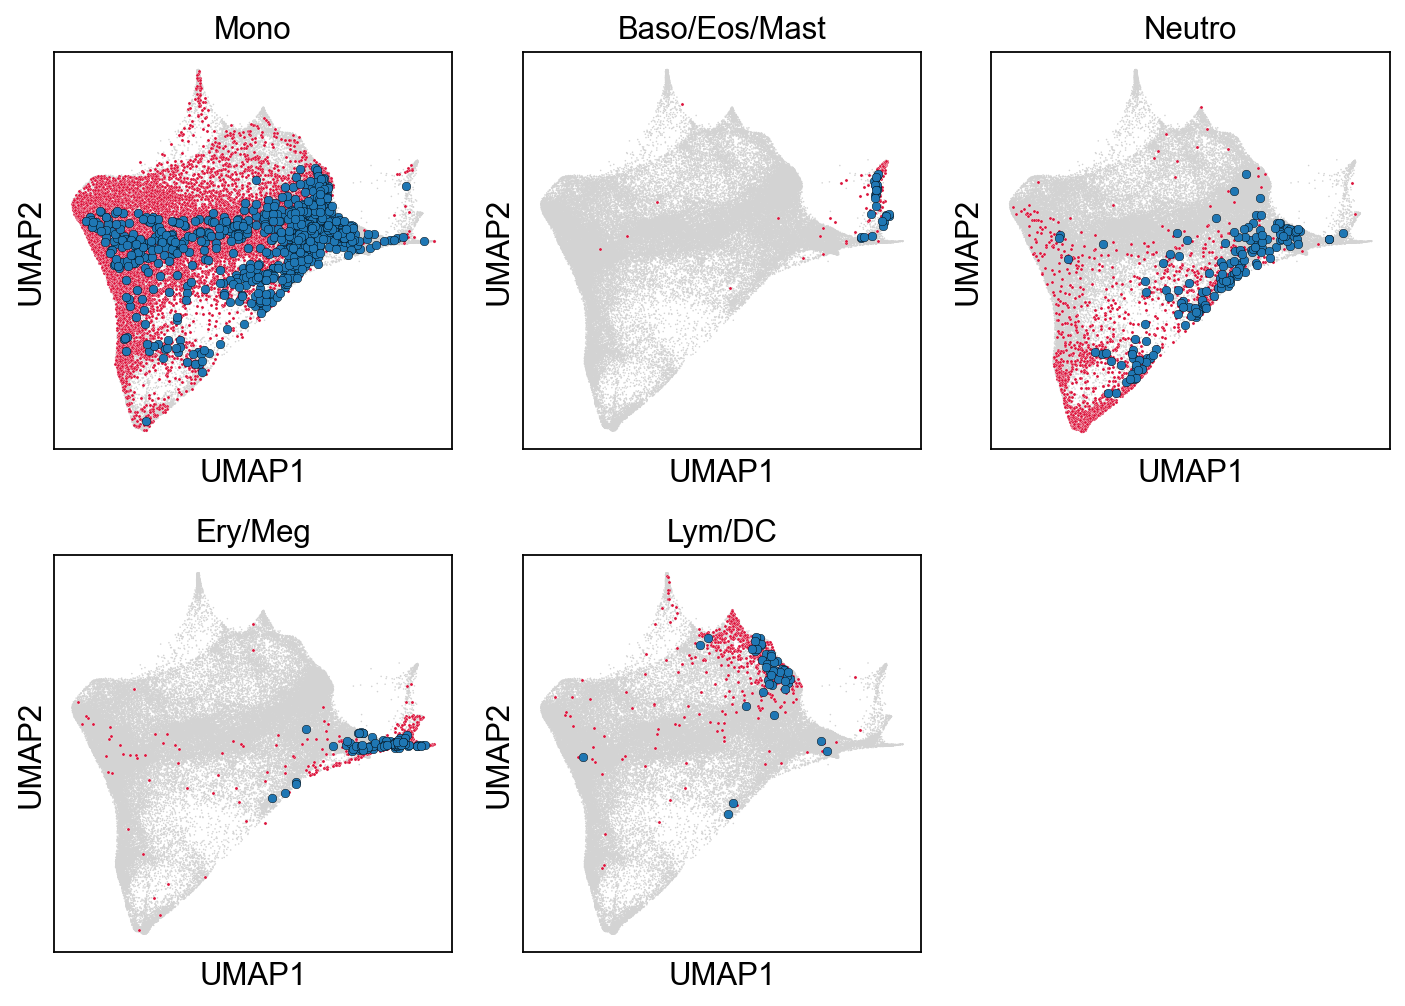

In [124]:
fig = plt.figure(figsize=(9,6.5))
gs=GridSpec(2,3)

for fate_curr,i in zip(fates,gs):
    
    #subset to cells in state clones for given fate
    clones_rna_curr = clones_rna[(clones_rna['fate']==fate_curr) & (clones_rna['day']=='d2')].copy()
    clones_rna_curr_d5 = clones_rna[(clones_rna['fate']==fate_curr) & (clones_rna['day']=='d5')].copy()
    
    # print(len(clones_rna_curr))
    
    #plot umap
    ax=plt.subplot(i)
    sc.pl.umap(adata,ax=ax,show=False, title=fate_curr)
    # sc.pl.umap(adata, color="final_celltype_simplified", groups=fate_curr, ax=ax, alpha=0.5, show=False, legend_loc=None, title=fate_curr)
    sns.scatterplot(x='UMAP_1', y='UMAP_2', data=umap_df[umap_df.index.isin(clones_rna_curr_d5['cell.bc'])],
                    legend=False, s=2,color='crimson')
    sns.scatterplot(x='UMAP_1', y='UMAP_2', data=umap_df[umap_df.index.isin(clones_rna_curr['cell.bc'])],
                    legend=False, s=15, linewidth=0.2, edgecolor='black')
plt.tight_layout()

plt.savefig("221122_plots/rna_umap_state_fate_sisters.png", dpi=300,transparent=True)

In [126]:
clones_rna

,clone.id,cell.bc,edge.den,cell_type2,day,fate,fate_pct
0,1,d5r2-rna-GAAGCCCAGAAGTATC-1,0.826316,MPP,d5,MPP,47.368421
1,1,d5r2-rna-TGCTCCAGTTGTCATG-1,0.826316,MPP/GMP,d5,MPP,47.368421
2,1,d5r2-rna-TATCTTGGTGTTAAAG-4,0.826316,MPP/GMP,d5,MPP,47.368421
3,1,d5r2-rna-GGGAAGTCATGAATCC-4,0.826316,MPP/GMP,d5,MPP,47.368421
4,1,d2_5-rna-CTTTCAAGTGTACGCC-1,0.826316,MPP/GMP,d2,MPP,47.368421
...,...,...,...,...,...,...,...
34027,5779,d5r1-rna-ACGTCCTGTCTCGGGT-2,1.000000,Mono,d5,Mono,100.000000
34028,5780,d5r2-rna-CCCTCAAAGCTGTGCC-1,1.000000,Unk_3,d5,Unk_3,100.000000
34029,5780,d2_5-rna-TCTACCGCATAGCTGT-1,1.000000,MPP/GMP,d2,Unk_3,100.000000
34030,5781,d5r2-rna-TAGGGTTGTCCAGCAC-4,1.000000,Unk_2,d5,Unk_2,100.000000
